In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))

from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import SimpleITK as sitk
from lungmask import mask
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numba
from general_utils.utils import plot3, parse_points_reg, compute_TRE, convert_nda_to_itk, convert_itk_to_nda, register_image_w_mask, register_image_external, normalize_copd_to_HU
from general_utils.utils import save_pts, save_pts_itk, transform_points
import torch

sitk.ProcessObject.SetGlobalWarningDisplay(False)
sitk.ProcessObject.SetGlobalDefaultDebug(False)

this_path = Path().resolve().parent

In [2]:
# define train path
# make sure you have created the results and paramMaps directories. In paramMaps folder, save the desired external parameter fiiles (e.g. params0011)

kp_path = this_path/'data/copd/keypoints'
scans_path = this_path/'data/copd/scans/'
lung_masks_path = this_path/'data/copd/lungMasks/'
results_path = this_path/'data/copd/results/'
paramMaps_path = this_path/'data/copd/paramMaps/'

****Goal****


In the test, given INHALE (image and landmarks), predict EXHALE landmarks

**Originally**

INHALE -> Moving

Exhale -> Fixed

**Change order, for correct points transformation**

INHALE -> Fixed

Exhale -> Moving

In [3]:
# best lm_bspline p0011
# to save csv with results
exp_name = 'best_v4_lm_bspline1_p0011' 

# select which cases to run
cases = ['001', '002', '003', '004']

results = {}

# either to save the transformed inhale points
save_transformed_points = True
save_final_moving_image = True

for train_case in tqdm(cases, total=len(cases)):
    
    case_results = {}

    # read images and masks
    fixed_itk = sitk.ReadImage(str(scans_path/f'case_{train_case}_insp.nii.gz'))
    fixed_image = convert_itk_to_nda(fixed_itk)
    # fixed_itk = normalize_copd_to_HU(fixed_image, fixed_itk)
    fixed_mask = convert_nda_to_itk((fixed_image >= 0).astype(np.uint8), fixed_itk)

    fixed_lung_mask = sitk.ReadImage(str(lung_masks_path/f'case_{train_case}_insp.nii.gz'))

    moving_itk = sitk.ReadImage(str(scans_path/f'case_{train_case}_exp.nii.gz'))
    moving_image = convert_itk_to_nda(moving_itk)
    # moving_itk = normalize_copd_to_HU(moving_image, moving_itk)
    moving_mask = convert_nda_to_itk((moving_image >= 0).astype(np.uint8), moving_itk)

    moving_lung_mask = sitk.ReadImage(str(lung_masks_path/f'case_{train_case}_exp.nii.gz'))

    # # read points
    points_inhale = np.loadtxt(kp_path/f'case_{train_case}_insp.txt').astype(np.int16)
    points_exhale = np.loadtxt(kp_path/f'case_{train_case}_exp.txt').astype(np.int16)

    pm_affine = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.affine.txt'))
    pm_bspline_1 = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.bspline1_s.txt'))
    pm_bspline_2 = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.bspline2_s.txt'))

    moving_reg, mov_param = register_image_external(fixed_image=fixed_itk, fixed_mask=fixed_lung_mask, 
                                                    moving_image=moving_itk, moving_mask=moving_lung_mask, paramMaps=[pm_bspline_1],
                                                    print_console=False)
    
    moving_lm = register_image_w_mask(fixed_image=None, moving_image=moving_lung_mask, fixed_mask=None, moving_mask=None,
                                        transformParameterMap=mov_param, interpolator='nn')[0]
    
    points_inhale_moved = transform_points(moving_itk=moving_reg, mov_param=mov_param,
                                            fixed_points_path=kp_path/f"case_{train_case}_insp.pts",
                                            output_dir=results_path, train_case=train_case)

    case_results['baseline'] = compute_TRE(points_exhale, points_inhale, voxel_spacing=moving_itk.GetSpacing())
    case_results['final'] = compute_TRE(points_exhale, points_inhale_moved, voxel_spacing=moving_itk.GetSpacing())
    
    print(f"Baseline TRE: {case_results['baseline']}")
    print(f"Registration (final) TRE: {case_results['final']}")

    if save_transformed_points:
        save_pts(points_inhale_moved, results_path/f'best_v4/case_{train_case}_insp_moved.txt')

    if save_final_moving_image:
        sitk.WriteImage(moving_reg, str(results_path/f'best_v4/case_{train_case}_insp_moved.nii.gz'))   
        sitk.WriteImage(moving_lm, str(results_path/f'best_v4/lm_case_{train_case}_insp_moved.nii.gz')) 

    results[train_case] = case_results

pd.DataFrame(results).to_csv(results_path/f'{exp_name}.csv')

  0%|          | 0/4 [00:00<?, ?it/s]

Baseline TRE: (26.5212958095204, 11.498190061390533)
Registration (final) TRE: (1.9958977952050354, 2.539956667704516)


 25%|██▌       | 1/4 [05:37<16:51, 337.23s/it]

Baseline TRE: (21.93124759248582, 6.505994990605793)
Registration (final) TRE: (3.032350701651524, 4.480832158821237)


 50%|█████     | 2/4 [10:56<10:53, 326.57s/it]

Baseline TRE: (12.62588335216309, 6.381867428751379)
Registration (final) TRE: (1.3540151071869007, 1.1717727295667966)


 75%|███████▌  | 3/4 [16:40<05:34, 334.52s/it]

Baseline TRE: (29.583559738904107, 12.92417092574431)
Registration (final) TRE: (1.5276140197896555, 1.1364630564748206)


100%|██████████| 4/4 [22:09<00:00, 332.31s/it]


In [3]:
# 3c - v2
# to save csv with results
exp_name = '3c_cyl_mask_aff_lm-set0_bspline2_p0011' 

# select which cases to run
cases = ['001'] #, '002', '003', '004']

results = {}

# either to save the transformed inhale points
save_transformed_points = True
save_final_moving_image = True

for train_case in tqdm(cases, total=len(cases)):
    
    case_results = {}

    # read images and masks
    fixed_itk = sitk.ReadImage(str(scans_path/f'case_{train_case}_insp.nii.gz'))
    fixed_image = convert_itk_to_nda(fixed_itk)
    # fixed_itk = normalize_copd_to_HU(fixed_image, fixed_itk)
    fixed_mask = convert_nda_to_itk((fixed_image >= 0).astype(np.uint8), fixed_itk)

    fixed_lung_mask = sitk.ReadImage(str(lung_masks_path/f'case_{train_case}_insp.nii.gz'))

    moving_itk = sitk.ReadImage(str(scans_path/f'case_{train_case}_exp.nii.gz'))
    moving_image = convert_itk_to_nda(moving_itk)
    # moving_itk = normalize_copd_to_HU(moving_image, moving_itk)
    moving_mask = convert_nda_to_itk((moving_image >= 0).astype(np.uint8), moving_itk)

    moving_lung_mask = sitk.ReadImage(str(lung_masks_path/f'case_{train_case}_exp.nii.gz'))

    # # read points
    points_inhale = np.loadtxt(kp_path/f'case_{train_case}_insp.txt').astype(np.int16)
    points_exhale = np.loadtxt(kp_path/f'case_{train_case}_exp.txt').astype(np.int16)

    # read param 11
    pm_affine = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.affine.txt'))
    pm_bspline_1 = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.bspline1_s.txt'))
    pm_bspline_2 = sitk.ReadParameterFile(str(paramMaps_path/'Parameters.Par0011.bspline2_s.txt'))

    # affine p11 transformation with cyl mask

    moving_reg_aff, mov_param = register_image_external(fixed_image=fixed_itk, fixed_mask=fixed_mask, 
                                                    moving_image=moving_itk, moving_mask=moving_mask, 
                                                    paramMaps=[pm_affine], print_console=False)
                                                    
    moving_lm_aff = register_image_w_mask(fixed_image=None, moving_image=moving_lung_mask, fixed_mask=None, moving_mask=None,
                                            transformParameterMap=mov_param, interpolator='nn')[0]
    
    points_inhale_moved_aff = transform_points(moving_itk=moving_itk, mov_param=mov_param, 
                                            fixed_points_path=kp_path/f"case_{train_case}_insp.pts",
                                            output_dir=results_path/'affine/', train_case=train_case)

    case_results['baseline'] = compute_TRE(points_exhale, points_inhale, voxel_spacing=moving_itk.GetSpacing())
    case_results['aff'] = compute_TRE(points_exhale, points_inhale_moved_aff, voxel_spacing=moving_itk.GetSpacing())
        
    print(f"Baseline TRE: {case_results['baseline']}")
    print(f"Registration (affine) TRE: {case_results['aff']}")
    
    # bspline1 p11 transformation with cyl mask
    moving_reg_bs1, mov_param = register_image_external(fixed_image=fixed_itk, fixed_mask=fixed_mask, 
                                                    moving_image=moving_reg_aff, moving_mask=moving_mask, 
                                                    paramMaps=[pm_bspline_1], print_console=False)

    moving_lm_bs1 = register_image_w_mask(fixed_image=None, moving_image=moving_lm_aff, fixed_mask=None, moving_mask=None,
                                            transformParameterMap=mov_param, interpolator='nn')[0]
    
    points_inhale_moved_bs1 = transform_points(moving_itk=moving_itk, mov_param=mov_param, 
                                            fixed_points_path=results_path/f'affine/case_{train_case}_outputpoints.pts',
                                            output_dir=results_path/'bs1/', train_case=train_case)
    
    case_results['bspline1'] = compute_TRE(points_exhale, points_inhale_moved_bs1, voxel_spacing=moving_itk.GetSpacing())
    print(f"Registration (bspline) TRE: {case_results['bspline1']}")

    # bspline2 p11 transformation without mask, but moving image set to 0 outside lungmask



  0%|          | 0/1 [00:00<?, ?it/s]

Baseline TRE: (26.5212958095204, 11.498190061390533)
Registration (affine) TRE: (13.57148135718135, 5.9894783518366665)


100%|██████████| 1/1 [03:19<00:00, 199.87s/it]

Registration (bspline) TRE: (9.911326847702082, 5.098721976696372)


In [5]:
print(np.unique(convert_itk_to_nda(moving_lm_bs1), return_counts=True))

print(np.unique(convert_itk_to_nda(moving_reg_bs1) > 0, return_counts=True))

mr_bs1_masked = moving_lm_bs1 * moving_reg_bs1
print(np.unique(convert_itk_to_nda(mr_bs1_masked) > 0, return_counts=True))

(array([0., 1.], dtype=float32), array([24816764,  6902660]))
(array([False,  True]), array([ 6335454, 25383970]))
(array([False,  True]), array([24817818,  6901606]))


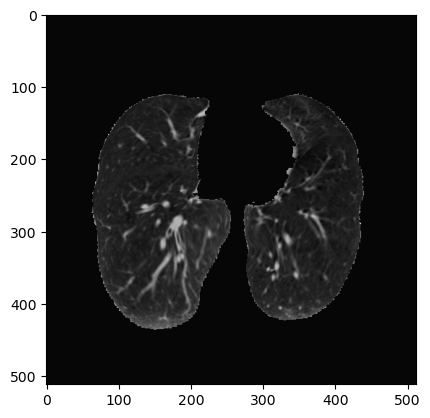

In [7]:
plt.imshow(convert_itk_to_nda(mr_bs1_masked)[:, :, 80], cmap='gray')

In [8]:
mr_bs1_masked = moving_lm_bs1 * moving_reg_bs1

moving_reg_bs2, mov_param = register_image_external(fixed_image=fixed_itk, fixed_mask=None, 
                                                moving_image=mr_bs1_masked, moving_mask=None, 
                                                paramMaps=[pm_bspline_2], print_console=False)

moving_lm_bs2 = register_image_w_mask(fixed_image=None, moving_image=moving_lm_bs1, fixed_mask=None, moving_mask=None,
                                        transformParameterMap=mov_param, interpolator='nn')[0]

points_inhale_moved_bs2 = transform_points(moving_itk=moving_itk, mov_param=mov_param, 
                                        fixed_points_path=results_path/f'bs1/case_{train_case}_outputpoints.pts',
                                        output_dir=results_path, train_case=train_case)

case_results['bspline2'] = compute_TRE(points_exhale, points_inhale_moved_bs2, voxel_spacing=moving_itk.GetSpacing())
print(f"Registration (bspline) TRE: {case_results['bspline2']}")

# if save_transformed_points:
#     save_pts(points_inhale_moved_bs2, results_path/f'case_{train_case}_insp_moved.txt')
# if save_final_moving_image:
#     sitk.WriteImage(moving_reg_bs2, results_path/f'case_{train_case}_insp_moved.nii.gz')   
#     sitk.WriteImage(moving_lm_bs2, results_path/f'lm_case_{train_case}_insp_moved.nii.gz') 
results[train_case] = case_results

# pd.DataFrame(results).to_csv(results_path/f'{exp_name}.csv')

Registration (bspline) TRE: (53.38703087671953, 18.270747518408484)
